# Localization with a known map  - Tutorial: Part 1

Localization with a known map, where the map is given as family of line segments. Moreover we optionally allow the environment to be clutterd with additional boxes, which are not mapped. We refer to such a map as _idealized_. ...

In the first part we will define all the sub parts of the localization model
- Pose prior
- Control prior
- Motion model
- Sensor model
  - Plug and play version using Gen distributions and mixture and product types
  - Performance optimized version with custom Gen distribution



In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
#nbx --fname="src/localization_part_1.jl"
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using BenchmarkTools;
using CUDA
using LaTeXStrings
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt # Python-style f-strings
using MyUtils
using StatsBase: mean
using Random: shuffle
include("../src/pose.jl");
include("src/plotting.jl");

We included a bunch of stuff there including:
 - `Pose(x,hd)` and `Control(dx, dhd)` types (with plenty of convenient methods to process them) ,
 - Just some plotting stuff that is useful later.
 - ...


Our SLAM model needs data to run on.
 By running the cell below we include a bunch of variables including: 
 - ground truth poses `_ps`, 
 - ground truth controls `_us`, 
 - the line segments forming the environment `_segs`,
 - ...



In [3]:
#nbx
# Load the environment and poses
include("src/house_expo_data.jl");

Loading `../data/data_4.jld2` ...

	_segs      Vector{Segment}
	_boxes     Vector{Segment}
	_center    Vector{Float64}
	_xs        Vector{Vector{Float64}}
	_hds       Vector{Float64}
	_ps        Vector{Pose}
	_dxs       Vector{Vector{Float64}}
	_dhds      Vector{Float64}
	_us        Vector{Control}
	_T         Int64


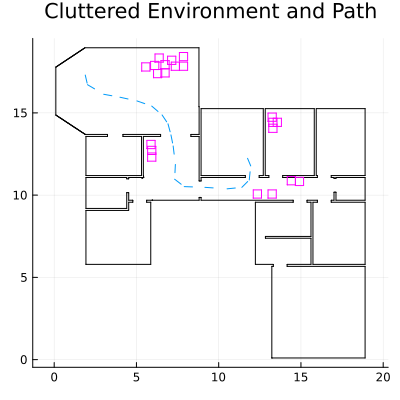

In [4]:
# -----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing, title="Cluttered Environment and Path")
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:magenta)
plot!(_ps, c=col[1])

Note that the data does not contain any measurement data. We are going take those measurement ourselves. To do so
let's include some files with deterministic depth sensors so we can make measurements. 

In [10]:
#nbx
include("../src/cuda_raycaster_line_map_b.jl")

_fov = 2π
_num_a = 361
_as  = [range(-_fov/2, _fov/2, _num_a)...];

_segs_  = CuArray(stack(Vector.(_segs)));
_boxes_ = CuArray(stack(Vector.(_boxes)));
_ps_    = CuArray(stack(Vector.(_ps)));
_as_    = CuArray(_as);


# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
zs_ = cast_cu(_ps_, vcat(_segs_, _boxes_); fov=_fov)
_zs = unstack(Array(zs_));
_ys = [polar_inv(z,_as) for z in _zs]

print("""Created a few new variables ...
    _fov     $(typeof(_fov)) 
    _as      $(typeof(_as))
    _zs      $(typeof(_zs)) 
    _ys      $(typeof(_ys)) 
""")

Created a few new variables ...
    _fov     Float64 
    _as      Vector{Float64}
    _zs      Vector{Vector{Float64}} 
    _ys      Vector{Vector{Vector{Float64}}} 


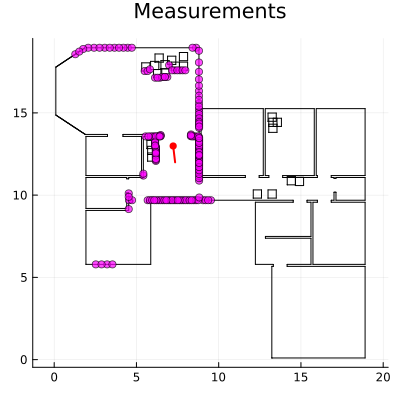

In [7]:
t = 10
p = _ps[t]
y = _ys[t]

# -----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing, title="Measurements")
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:black)
scatter!(p, c=:red, r=1.0, linewidth=2)
scatter!(shuffle(y[1:2:end]).*p, c=:magenta, markersize=4, alpha=.7, markerstrokewidth=1)

The agent will only have access to 
- the observations (`_zs` and `_as`; or the Euclidean version `_ys`), 
- the idealized map (`_segs`), and 
- a perturbed version of the controls (`_us_noisy`; wil lbe constructrd below).

Its goal is localize itself on the idealized map.

## Model parts

A couple of distributions we need down the line: a diagonal normal distribution `diagnormal` and a multivariate uniform distribution `mvuniform`.

In [11]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(2), ones(2))

2-element Vector{Float64}:
 0.6499658652561995
 0.07053505657941184

### Pose-prior model

In [12]:
#nbx
"""
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45.)

Model depends on global variable `_bb`.
"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45/360*2π, bb=_bb)
    # Todo: better signature would be to ask if p is pose or a bounding box
    if p == nothing
        x  ~ mvuniform(bb...)
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    end
    return Pose(x, hd)
end;

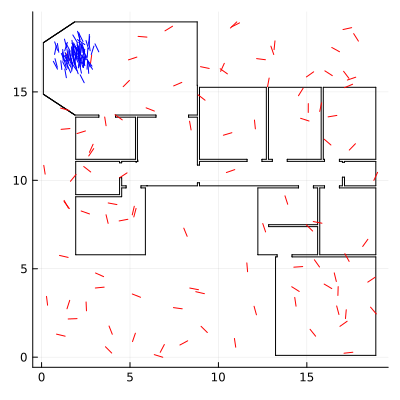

In [13]:
ps = [pose_prior_model(nothing) for t=1:100]
qs = [pose_prior_model(_ps[1], .5, 15/360*2π) for t=1:100]

# ----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(ps,c=:red)
plot!(qs,c=:blue)

### Control Prior

We don't use the prior at the moment. We assume the controls are given.

In [14]:
#nbx
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;

### Motion model

In [15]:
#nbx
"""
    q = motion_model(p, u, x_noise, hd_noise)

Sample a new pose `q` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise`.
"""
@gen function motion_model(p, u, x_noise, hd_noise)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return Pose(x, hd)
end;

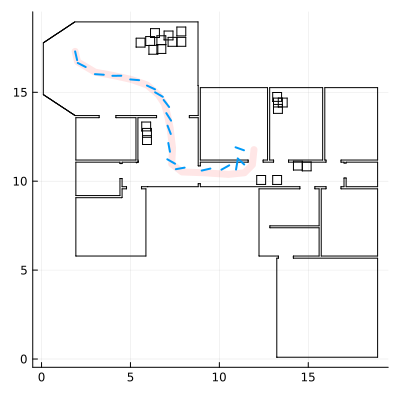

In [16]:
ps = Pose[_ps[1]]

for u in _us
    p = motion_model(ps[end], u, 1e-1, 2\pi * 1e-1)       
    push!(ps, p)
end
ps = [p for p in ps]

# ---------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:black, linewidth=1)
plot!([p.x for p in _ps], c=:red, linewidth=7, alpha=0.1)
plot!(ps, c=col[1], linewidth=2)

### Sensor model

The sensor model will be based on
 - `cast_cu` &mdash; a CUDA accelerated deterministic raycaster for point clouds, 
 - `get_2d_mixture_components` &mdash; a method to compute the 2dp3 mixture components, and
 - `sensodist_cu` &mdash; a sensor distribution implementing the 2dp3-likelihood.
  
By running the cell below we will include these methods; you can display more detailed description of each by calling `@doc` on them.

We will then proceed by defining the sensor model.

In [17]:
#nbx
include("src/sensor_distribution.jl")

#### Drag and drop version

Build the 2dp3 likelihood combining already defined Gen distributions and types... This explicit but slow...

In [25]:
gm             = HomogeneousMixture(diagnormal, [1, 1])
outlier_dist   = diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = ProductDistribution(sensor_mix)

function sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    n,m, = size(ỹ)
    ỹ_perm = permutedims(ỹ, (1,3,2))
    args = (
        fill([1-outlier, outlier], n), 
        fill(1/m, n, m), 
        ỹ_perm, 
        fill(sig, n, 2,m), 
        fill(0.0, n,2), 
        fill(zmax, n,2)
    )
    return args
end

ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.
args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
x = sensor_product(args...)

@btime sensor_product($args...) samples=3 evals=3;
@btime logpdf($sensor_product, $x, $args...) samples=3 evals=3;

  2.686 ms (16890 allocations: 1.02 MiB)
  16.247 ms (161736 allocations: 5.66 MiB)


In [22]:
@gen function sensor_model_v1(p, segs_, w, sig, outlier, outlier_vol, zmax)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)

    zs_ = cast_cu(ps_, segs_; fov=_fov)    
    ỹ_  = get_2d_mixture_components(zs_, _as_, w)[1,:,:,:]
    ỹ   = Array(ỹ_)

    args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    x ~ sensor_product(args...)
    
    return x
end;

In [24]:
t = 7

p  = _ps[t]
m_ = _segs_

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0
zmax         = 100.0

args  = (p, m_, w, s_noise, outlier, outliver_vol, zmax)
sensor_model_v1(args...)
tr = simulate(sensor_model_v1, args);
get_choices(tr)

│
└── :x : [[Inf, Inf], [Inf, Inf], [-5.127827100955425, -0.5431947412316388], [52.096464726259896, 33.060811732436676], [-5.6182556595143724, -0.37262895182471445], [-5.204774538194521, -0.6085017167145986], [-5.6181098975365895, -1.0079767169415754], [-5.714158745463338, -0.9201480124814314], [-5.885599385235262, -1.1908195045627337], [-5.374963187174644, -0.6467586845834172], [-6.243613866199486, -1.6264688505517215], [-5.653052979387513, -1.289445048421441], [-5.071893783385505, -0.7436376856135531], [-5.595006879780771, -0.9214350026838123], [-5.4014696867744725, -0.7808934051054115], [-5.818182559298101, -1.9616934253193181], [-6.1905518180209995, -1.3038235315137765], [-6.152652329374617, -2.2086989069463234], [-6.142825353021968, -2.4952460242595027], [-6.095407696053091, -2.074272009160921], [67.15730887986852, 109.81049445546738], [2.417211142932773, 113.09362680543549], [-6.150797930217805, -2.79665843864889], [-6.0722479109251015, -1.877298533343566], [-5.842402952086904, -

In [73]:
t = 7

p  = _ps[t]
m_ = _segs_

w            = 5
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100


args  = (p, m_, w, s_noise, outlier, outlier_vol, zmax)
x  = sensor_model_v1(args...)
ch = choicemap(:x => x)

@btime sensor_model_v1($args...)              samples=5 evals=5;
@btime simulate($sensor_model_v1, $args)      samples=5 evals=5;
@btime generate($sensor_model_v1, $args, $ch) samples=5 evals=5;

  2.468 ms (17367 allocations: 1.01 MiB)
  12.446 ms (110487 allocations: 4.20 MiB)
  10.360 ms (93567 allocations: 3.38 MiB)


Difference between `simulate` and `generate` comes from the additional sampling time. Both need to evaluate.

```julia
  2.441 ms (17352 allocations: 1.01 MiB)
  12.194 ms (110495 allocations: 4.20 MiB)
  10.197 ms (93567 allocations: 3.38 MiB)
```

#### Customized version

Use a custom Gen distribution `sensordist_cu` to define a more performant version of the above sensor model. 

In [85]:
@doc sensordist_cu

```julia
    x = sensordist_cu(ỹ_::CuArray, sig, outlier, outlier_vol=1.0)::Vector{Vector{Float64}}
```

Distribution from the 2dp3-likelihood. Takes 2d-mixture components `ỹ_` and samples a vector `x` of 2d points.

Arguments:

  * `ỹ_`: 2d-mixture components `(n,m,2)`
  * ...

Returns:

  * `x`: Observation vector of 2d points.


In [29]:
#nbx
@gen function sensor_model(p, segs, w, s_noise, outlier, outlier_vol, zmax=100.0)
    segs_ = CuArray(stack(Vector.(_segs)))
    p_    = CuArray(Vector(p))
    ps_   = reshape(p_, 1, 3)

    zs_      = cast_cu(ps_, segs_; fov=_fov)
    as_      = CuArray(_as)
    y_tilde_ = get_2d_mixture_components(zs_, as_, w)[1,:,:,:]

    x ~ sensordist_cu(y_tilde_, s_noise, outlier, outlier_vol)    
    return x
end;

In [30]:
ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.

ỹ_   = CuArray(ỹ)
args = (ỹ_, sig, outlier, outlier_vol) 
x = sensordist_cu(args...)

@btime sensordist_cu($args...)              samples=3 evals=3;
@btime logpdf($sensordist_cu, $x, $args...) samples=3 evals=3;

  11.465 ms (16466 allocations: 770.30 KiB)
  449.659 μs (592 allocations: 52.52 KiB)


In [35]:
t = 7

p  = _ps[t]
m_ = _segs_

w            = 5
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100

args  = (p, m_, w, s_noise, outlier, outlier_vol, zmax)
x  = sensor_model(args...)
ch = choicemap(:x => x)

@btime sensor_model($args...)              samples=5 evals=5;
@btime simulate($sensor_model, $args)      samples=5 evals=5;
@btime generate($sensor_model, $args, $ch) samples=5 evals=5;

  12.123 ms (17611 allocations: 864.49 KiB)
  12.556 ms (18097 allocations: 913.45 KiB)
  1.074 ms (1714 allocations: 152.14 KiB)


Difference between `simulate` and `generate` comes from the additional sampling time. Both need to evaluate.

```julia
  12.123 ms (17611 allocations: 864.49 KiB)
  12.556 ms (18097 allocations: 913.45 KiB)
  1.074 ms (1714 allocations: 152.14 KiB)
```

  12.308 ms (17721 allocations: 869.41 KiB)
  13.049 ms (18209 allocations: 918.44 KiB)
  1.084 ms (1730 allocations: 152.45 KiB)


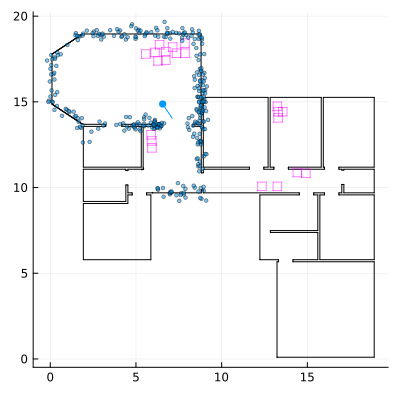

In [38]:
t = 7

p  = _ps[t]
m_ = _segs_

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0

args  = (p, m_, w, s_noise, outlier, outliver_vol)

tr = simulate(sensor_model, args)
x = tr[]

ch = choicemap(:x => x)

@btime sensor_model(args...)            samples=3 evals=3;
@btime simulate(sensor_model, args)     samples=3 evals=3;
@btime generate(sensor_model, args, ch) samples=5 evals=5;

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(_boxes, c=:magenta, alpha=0.5)
scatter!(x.*_ps[t], c=col[1], alpha=0.5, markersize=2)
scatter!(_ps[t], c=col[1])